<a href="https://colab.research.google.com/github/Duirta/Stock-Portfolio-Allocator/blob/main/Stock_Prediction_with_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

     |████████████████████████████████| 5.5MB 6.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=856d053727b463de51a651cd47e0167ea1157165ba063706e9501be05ae301ce
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
%tensorflow_version 2.x

import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime
from scipy.stats import levy_stable
import os

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [ ]:
companies = open('sp_500_stocks.csv','r')
companies = companies.readlines()
companies = [line.replace('\n','') for line in companies[1:]]

In [ ]:
def get_stock(company_name, start_date, end_date):
  ''' Returns the stock price and the daily changes in the logarithm of the price for a given company '''
  company = yf.download(company_name,start_date,end_date)
  company_price = np.array(company['Adj Close'])
  y = np.log(company_price)
  r = np.array([y[n]-y[n-1] for n in range(1,len(y)) if str(y[n]-y[n-1]) != 'nan'])
  return company_price, r

def get_date(start_date,end_date):
  ''' Returns array of the days where the stock market was open for a given time period '''
  company = yf.download('AAPL',start_date,end_date)
  datas = np.array(company.index)
  return datas

In [ ]:
r = dict()
'''
stock_price = dict()
datas = get_date('2015-01-01','2019-01-01')
for company in companies:
  stock_company, r_company = get_stock(company,'2015-01-01','2019-01-01')
  if len(r_company) == len(datas)-1:
    r[company] = r_company
  if len(stock_company) == len(datas):
    stock_price[company] = stock_company
'''


"\nstock_price = dict()\ndatas = get_date('2015-01-01','2019-01-01')\nfor company in companies:\n  stock_company, r_company = get_stock(company,'2015-01-01','2019-01-01')\n  if len(r_company) == len(datas)-1:\n    r[company] = r_company\n  if len(stock_company) == len(datas):\n    stock_price[company] = stock_company\n"

In [ ]:
np.random.seed(1)

def train_test_split(dicto, train_ratio = 0.5):
  ''' Splits the set of companies and their daily changes into training and testing data '''
  train_keys = np.random.choice(list(dicto.keys()), size = round(train_ratio*len(dicto.keys())))
  test_keys = [key for key in dicto.keys() if key not in train_keys]

  train_data = np.array([list(dicto[key]) for key in train_keys])
  test_data = np.array([list(dicto[key]) for key in test_keys])
  return train_data, test_data, train_keys, test_keys

def partition_data(x, length = 10):
  ''' Partitions the data into chunks '''
  n_stocks, timelength = x.shape
  length_per_stock = timelength-length
  partitions = []
  for i in range(n_stocks):
    for j in range(length_per_stock):
      partitions.append(x[i,j:j+length])
  return np.array(partitions)

def normalize_part(partitions, minimum = None, maximum = None):
  ''' Normalizes the data '''
  normalized = []
  if minimum == None or maximum == None:
    minimum = np.min(partitions)
    maximum = np.max(partitions)
  for partition in partitions:
    normalized.append((partition-minimum)/(maximum-minimum))
  return np.array(normalized)

def in_and_out(partitions):
  ''' Splits the partitions into input and output data '''
  x, y = [], []
  for partition in partitions:
    x.append(np.array([partition[:-1]]))
    y.append(np.array([partition[-1]]))
  return np.array(x), np.array(y)

def train_test(dicto, train_ratio = 0.5, input_length = 10):
  ''' Splits a dictionary of arrays into training and testing data '''
  train_data, test_data, train_keys, test_keys = train_test_split(dicto, train_ratio)

  flat_train_data = train_data.flatten()
  flat_train_data.sort()
  minimum = flat_train_data[round(0.01*len(flat_train_data))]
  maximum = flat_train_data[round(0.99*len(flat_train_data))]

  train_partitions = partition_data(train_data, input_length + 1)
  test_partitions = partition_data(test_data, input_length + 1)

  train_partitions = normalize_part(train_partitions, minimum, maximum)
  test_partitions = normalize_part(test_partitions, minimum, maximum)

  x_train, y_train = in_and_out(train_partitions)
  x_test, y_test = in_and_out(test_partitions)

  return x_train, y_train, x_test, y_test, train_keys, test_keys, flat_train_data, minimum, maximum

train_data, test_data, train_keys, test_keys = train_test_split(r, 0.7)

find_fit = False
if find_fit:
  fitting_data = train_data.flatten()
  fitting_data.sort()
  fitting_data = [fitting_data[i] for i in range(0,len(fitting_data),4000)]
  alpha, beta, mu, c = levy_stable.fit(fitting_data)
else:
  alpha = 1.5455908322164555
  beta = -0.2393705235288907
  mu = -0.0004973090984573017
  c = 0.008261207967671467

print('alpha:', alpha)
print('beta:', beta)
print('mu', mu)
print('c:', c)

#x_train, y_train, x_val, y_val, train_keys, test_keys, flat_train_data, minimum, maximum = train_test(r, 0.7, 10)
#print(f'Number of training examples: {len(x_train)}')

alpha: 1.5455908322164555
beta: -0.2393705235288907
mu -0.0004973090984573017
c: 0.008261207967671467


In [ ]:
if 'normalized_training_data.csv' in os.listdir():
  norm_train_data = np.loadtxt('normalized_training_data.csv',delimiter=';')
  norm_test_data = np.loadtxt('normalized_testing_data.csv',delimiter=';')
else:
  norm_train_data = levy_stable.cdf(train_data, alpha, beta, mu, c)
  norm_test_data = levy_stable.cdf(test_data, alpha, beta, mu, c)

  np.savetxt('normalized_training_data.csv',norm_train_data,delimiter=';')
  np.savetxt('normalized_testing_data.csv',norm_test_data,delimiter=';')

In [ ]:
input_length = 100
train_partitions = partition_data(norm_train_data, input_length + 1)
test_partitions = partition_data(norm_test_data, input_length + 1)
x_train, y_train = in_and_out(train_partitions)
x_val, y_val = in_and_out(test_partitions)
print(f'Number of training examples: {len(x_train)}')

Number of training examples: 305552


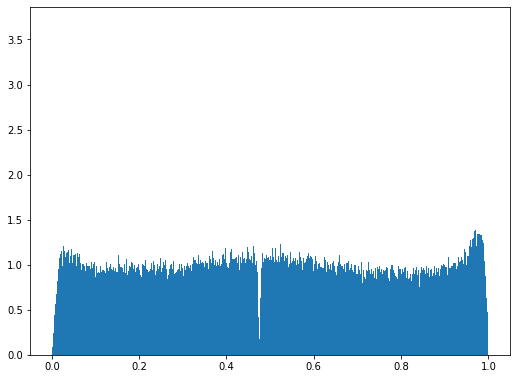

In [ ]:
plt.figure(figsize=(8.6,6.4))
plt.hist(norm_train_data.flatten(), bins = round(np.sqrt(len(norm_train_data.flatten()))), density = True)
x1,x2,y1,y2 = plt.axis()
#plt.plot(np.linspace(x1,x2,500),levy_stable.pdf(np.linspace(x1,x2,500),alpha,beta,mu,c))
plt.show()

In [ ]:
x_train[0].shape

(1, 100)

In [ ]:
n_epochs = 20

In [ ]:
model1 = Sequential([
        LSTM(1, input_shape = (1,input_length))
])

model1.compile(optimizer='adam', loss='mse', metrics = ['mae'])

In [ ]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1)                 48        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history1 = model1.fit(x_train, y_train, epochs = n_epochs, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/5
10500/10500 [==============================] - 44s 4ms/step - loss: 0.1024 - mae: 0.2665 - val_loss: 0.0812 - val_mae: 0.2446
Epoch 2/5
10500/10500 [==============================] - 43s 4ms/step - loss: 0.0819 - mae: 0.2459 - val_loss: 0.0812 - val_mae: 0.2445
Epoch 3/5
10500/10500 [==============================] - 43s 4ms/step - loss: 0.0816 - mae: 0.2451 - val_loss: 0.0811 - val_mae: 0.2443
Epoch 4/5
10500/10500 [==============================] - 43s 4ms/step - loss: 0.0817 - mae: 0.2455 - val_loss: 0.0810 - val_mae: 0.2441
Epoch 5/5
10500/10500 [==============================] - 43s 4ms/step - loss: 0.0817 - mae: 0.2453 - val_loss: 0.0810 - val_mae: 0.2441


In [ ]:
model1.save('r_predicting_network1.h5')

In [ ]:
model2 = Sequential([
        LSTM(10, input_shape = (1,input_length)),
        Dense(1,activation = 'relu')
])

model2.compile(optimizer='adam', loss='mse', metrics = ['mae'])
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2 = model2.fit(x_train, y_train, epochs = n_epochs, batch_size=32, validation_data=(x_val, y_val))

In [ ]:
model2.save('r_predicting_network2.h5')

In [ ]:
model3 = Sequential([
        LSTM(10, return_sequences = True, input_shape = (1,input_length)),
        LSTM(35, return_sequences = True),
        Dropout(0.2),
        LSTM(50, return_sequences = True),
        Dropout(0.2),
        LSTM(35),
        Dropout(0.2),
        Dense(5, activation = 'sigmoid'),
        Dense(1,activation = 'sigmoid')
])

model3.compile(optimizer='adam', loss='mse', metrics = ['mae'])
model3.summary()

In [ ]:
history3 = model3.fit(x_train, y_train, epochs = n_epochs, batch_size=32, validation_data=(x_val, y_val))

In [ ]:
model3.save('r_predicting_network3.h5')

In [ ]:
model4 = Sequential([
        LSTM(input_length, return_sequences = True, input_shape = (1,input_length)),
        LSTM(100, return_sequences=True),
        LSTM(100, return_sequences=True),
        LSTM(60, return_sequences=True),
        Dropout(0.2),
        LSTM(35, return_sequences = True),
        LSTM(5),
        Dense(1,activation = 'sigmoid')
])

model4.compile(optimizer='adam', loss='mse', metrics = ['mae'])
model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 60)             38640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 60)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 35)             13440     
_________________________________________________________________
lstm_12 (LSTM)               (None, 5)                

In [ ]:
history4 = model4.fit(x_train, y_train, epochs = n_epochs, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/20
9549/9549 [==============================] - 137s 11ms/step - loss: 0.0817 - mae: 0.2453 - val_loss: 0.0782 - val_mae: 0.2388
Epoch 2/20
9549/9549 [==============================] - 101s 11ms/step - loss: 0.0757 - mae: 0.2335 - val_loss: 0.0727 - val_mae: 0.2259
Epoch 3/20
9549/9549 [==============================] - 102s 11ms/step - loss: 0.0691 - mae: 0.2198 - val_loss: 0.0705 - val_mae: 0.2202
Epoch 4/20
9549/9549 [==============================] - 100s 10ms/step - loss: 0.0658 - mae: 0.2128 - val_loss: 0.0691 - val_mae: 0.2172
Epoch 5/20
9549/9549 [==============================] - 101s 11ms/step - loss: 0.0634 - mae: 0.2080 - val_loss: 0.0675 - val_mae: 0.2130
Epoch 6/20
9549/9549 [==============================] - 100s 10ms/step - loss: 0.0615 - mae: 0.2041 - val_loss: 0.0673 - val_mae: 0.2128
Epoch 7/20
9549/9549 [==============================] - 101s 11ms/step - loss: 0.0599 - mae: 0.2006 - val_loss: 0.0662 - val_mae: 0.2105
Epoch 8/20
9549/9549 [===================

In [ ]:
model4.save('r_predicting_network4.h5')

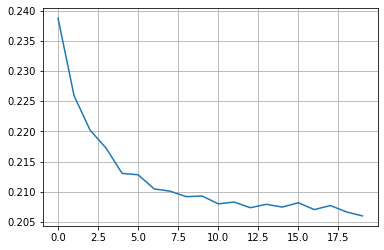

In [ ]:
plt.plot(list(history4.history['val_mae']))
plt.grid()
plt.show()

In [ ]:
model5 = Sequential([
        LSTM(250, return_sequences = True, input_shape = (1,input_length)),
        Dropout(0.2),
        LSTM(250, return_sequences = True),
        Dropout(0.2),
        LSTM(16),
        Dense(1,activation = 'sigmoid')
])

model5.compile(optimizer='adam', loss='mse', metrics = ['mae'])
model5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1, 250)            261000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 250)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 250)            501000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 250)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)                17088     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 779,105
Trainable params: 779,105
Non-trainable params: 0
________________________________________________

In [ ]:
history5 = model5.fit(x_train, y_train, epochs = n_epochs, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/50
10500/10500 [==============================] - 79s 7ms/step - loss: 0.0820 - mae: 0.2460 - val_loss: 0.0810 - val_mae: 0.2442
Epoch 2/50
10500/10500 [==============================] - 75s 7ms/step - loss: 0.0816 - mae: 0.2453 - val_loss: 0.0809 - val_mae: 0.2440
Epoch 3/50
10500/10500 [==============================] - 76s 7ms/step - loss: 0.0818 - mae: 0.2456 - val_loss: 0.0808 - val_mae: 0.2438
Epoch 4/50
10500/10500 [==============================] - 74s 7ms/step - loss: 0.0814 - mae: 0.2447 - val_loss: 0.0807 - val_mae: 0.2436
Epoch 5/50
10500/10500 [==============================] - 76s 7ms/step - loss: 0.0810 - mae: 0.2439 - val_loss: 0.0805 - val_mae: 0.2433
Epoch 6/50
10500/10500 [==============================] - 77s 7ms/step - loss: 0.0811 - mae: 0.2443 - val_loss: 0.0804 - val_mae: 0.2428
Epoch 7/50
10500/10500 [==============================] - 75s 7ms/step - loss: 0.0811 - mae: 0.2442 - val_loss: 0.0803 - val_mae: 0.2427
Epoch 8/50
10500/10500 [=================

In [ ]:
model5.save('r_predicting_network5.h5')

In [ ]:
model6 = Sequential([
        Conv1D(filters = 128, kernel_size = 5, padding = 'same', input_shape = (1,input_length)),
        Conv1D(filters = 64, kernel_size = 3, padding = 'same'),
        MaxPooling1D(pool_size = 2, padding = 'same'),
        Flatten(),
        Dense(50, activation = 'sigmoid'),
        Dense(30, activation = 'sigmoid'),
        Dense(1,activation = 'sigmoid')
])

model6.compile(optimizer='adam', loss='mse', metrics = ['mae'])
model6.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 1, 128)            6528      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 64)             24640     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                3250      
_________________________________________________________________
dense_19 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                

In [ ]:
history6 = model6.fit(x_train, y_train, epochs = n_epochs, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/25
10500/10500 [==============================] - 36s 3ms/step - loss: 0.0343 - mae: 0.1245 - val_loss: 0.0332 - val_mae: 0.1224
Epoch 2/25
10500/10500 [==============================] - 35s 3ms/step - loss: 0.0341 - mae: 0.1235 - val_loss: 0.0331 - val_mae: 0.1218
Epoch 3/25
10500/10500 [==============================] - 35s 3ms/step - loss: 0.0340 - mae: 0.1236 - val_loss: 0.0331 - val_mae: 0.1218
Epoch 4/25
10500/10500 [==============================] - 36s 3ms/step - loss: 0.0343 - mae: 0.1236 - val_loss: 0.0332 - val_mae: 0.1218
Epoch 5/25
10500/10500 [==============================] - 35s 3ms/step - loss: 0.0340 - mae: 0.1234 - val_loss: 0.0331 - val_mae: 0.1217
Epoch 6/25
10500/10500 [==============================] - 36s 3ms/step - loss: 0.0338 - mae: 0.1232 - val_loss: 0.0332 - val_mae: 0.1222
Epoch 7/25
10500/10500 [==============================] - 36s 3ms/step - loss: 0.0339 - mae: 0.1235 - val_loss: 0.0331 - val_mae: 0.1218
Epoch 8/25
10500/10500 [=================

In [ ]:
model6.save('r_predicting_network6.h5')

In [ ]:
model7 = Sequential([
        Conv1D(filters = 128, kernel_size = 5, padding = 'same', input_shape = (1,input_length)),
        Conv1D(filters = 128, kernel_size = 5, padding = 'same'),
        MaxPooling1D(pool_size = 2, padding = 'same'),
        Dropout(0.2),
        Conv1D(filters = 64, kernel_size = 3, padding = 'same'),
        Conv1D(filters = 64, kernel_size = 3, padding = 'same'),
        MaxPooling1D(pool_size = 2, padding = 'same'),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(16, return_sequences=True),
        Dense(1,activation = 'sigmoid')
])

model7.compile(optimizer='adam', loss='mse', metrics = ['mae'])
model7.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 1, 128)            6528      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 128)            82048     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1, 64)             24640     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1, 64)             12352     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1, 64)           

In [ ]:
history7 = model7.fit(x_train, y_train, epochs = n_epochs, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/25
10500/10500 [==============================] - 75s 7ms/step - loss: 0.0338 - mae: 0.1233 - val_loss: 0.0332 - val_mae: 0.1220
Epoch 2/25
10500/10500 [==============================] - 72s 7ms/step - loss: 0.0335 - mae: 0.1232 - val_loss: 0.0332 - val_mae: 0.1219
Epoch 3/25
10500/10500 [==============================] - 72s 7ms/step - loss: 0.0339 - mae: 0.1234 - val_loss: 0.0332 - val_mae: 0.1218
Epoch 4/25
10500/10500 [==============================] - 72s 7ms/step - loss: 0.0340 - mae: 0.1234 - val_loss: 0.0332 - val_mae: 0.1219
Epoch 5/25
10500/10500 [==============================] - 72s 7ms/step - loss: 0.0344 - mae: 0.1237 - val_loss: 0.0332 - val_mae: 0.1219
Epoch 6/25
10500/10500 [==============================] - 72s 7ms/step - loss: 0.0337 - mae: 0.1231 - val_loss: 0.0332 - val_mae: 0.1218
Epoch 7/25
10500/10500 [==============================] - 72s 7ms/step - loss: 0.0339 - mae: 0.1232 - val_loss: 0.0332 - val_mae: 0.1222
Epoch 8/25
10500/10500 [=================

In [ ]:
model7.save('r_predicting_network7.h5')

In [ ]:
model8 = Sequential([
        Dense(10, input_shape = (1,input_length), activation = 'sigmoid'),
        Dense(31, activation = 'sigmoid'),
        Dense(97, activation = 'sigmoid'),
        Dense(300, activation = 'sigmoid'),
        Dense(97, activation = 'sigmoid'),
        Dense(31, activation = 'sigmoid'),
        Dense(10, activation = 'sigmoid'),
        Dense(1, activation = 'sigmoid'),
])

model8.compile(optimizer='adam', loss='mse', metrics = ['mae'])
model8.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1, 10)             110       
_________________________________________________________________
dense_3 (Dense)              (None, 1, 31)             341       
_________________________________________________________________
dense_4 (Dense)              (None, 1, 97)             3104      
_________________________________________________________________
dense_5 (Dense)              (None, 1, 300)            29400     
_________________________________________________________________
dense_6 (Dense)              (None, 1, 97)             29197     
_________________________________________________________________
dense_7 (Dense)              (None, 1, 31)             3038      
_________________________________________________________________
dense_8 (Dense)              (None, 1, 10)            

In [ ]:
history8 = model8.fit(x_train, y_train, epochs = n_epochs, batch_size=32, validation_data=(x_val, y_val))

In [ ]:
model8.save('r_predicting_network8.h5')

In [ ]:
mus = [np.mean(seq) for seq in x_val]
dmus = [abs(mus[i] - y_val[i]) for i in range(len(mus))]
mae_mu = np.mean(dmus)

dlast_value = [abs(x_val[i][-1] - y_val[i]) for i in range(len(mus))]
mae_last_value = np.mean(dlast_value)
print(f'mae from averaging: {mae_mu:.4f}')
print(f'mae from last value: {mae_last_value:.4f}')

mae from averaging: 0.2543
mae from last value: 0.3246


In [ ]:
for i, fit_history in enumerate([history1, history2, history3, history4, history5, history6, history7, history8]):
  print(f'Model {i} last val_mae value: {np.array(list(fit_history.history.values()))[-1][-1]:.4f}')

In [ ]:
outputs = [[] for i in range(8)]
for i, model in enumerate([model1, model2, model3, model4, model5, model6, model7, model8]):
  print('Model', i+1)
  for seq in x_val[:10000]:
    x = model.predict(np.array([seq]))
    outputs[i].append(x.flatten()[0])
  plt.figure()
  plt.hist(outputs[i], bins = 100)
  plt.title(f'Output Shape of Model {i+1}')
  plt.show()
  plt.savefig(f'output_shape_model{i+1}.png')

In [ ]:
outputs = np.array(outputs)
np.savetxt('outputs.csv', outputs, delimiter = ';')

In [ ]:
outputs = np.loadtxt('outputs.csv', delimiter = ';')

In [ ]:
i = 0

In [ ]:
print(levy_stable.ppf(x_val[i][0],alpha,beta,mu,c))
print(f'Previsto: {levy_stable.ppf(model5.predict(np.array([x_val[i]]))[0,0],alpha,beta,mu,c):.4f}')
print(f'Média: {levy_stable.ppf(np.mean(x_val[i][0]),alpha,beta,mu,c):.4f}')
print(f'Real: {levy_stable.ppf(y_val[i][0],alpha,beta,mu,c):.4f}')
i+=10

[-0.00193026 -0.00949093  0.01740295  0.00658103  0.00527588  0.01254998
 -0.00500109 -0.01451887 -0.00190971 -0.0055363 ]
Previsto: 0.0017
Média: 0.0004
Real: 0.0140


In [ ]:
print(np.std(test_data))
print(c)

0.01650811859374638
0.008261207967671467


In [ ]:
np.mean([abs(levy_stable.ppf(model5.predict(np.array([x_val[i]]))[0,0],alpha,beta,mu,c) - levy_stable.ppf(y_val[i][0],alpha,beta,mu,c)) for i in range(1000)])

0.009763134716452949

### Trying to predict growth or decrease instead of next value

In [ ]:
zero = levy_stable.cdf(0,alpha, beta, mu, c)
x_bool_train = 0.5+0.5*np.sign(x_train-zero)
x_bool_val = 0.5+0.5*np.sign(x_val-zero)
y_bool_train = 0.5+0.5*np.sign(y_train-zero)
#y_bool_train = np.array([([[1,0]],[[0,1]])[round(i[0])] for i in y_bool_train])
y_bool_val = 0.5+0.5*np.sign(y_val-zero)
#y_bool_val = np.array([([[1,0]],[[0,1]])[round(i[0])] for i in y_bool_val])

In [ ]:
x_bool_train = x_bool_train[:,0]
x_bool_val = x_bool_val[:,0]
y_bool_train = y_bool_train[:,0]
y_bool_val = y_bool_val[:,0]

In [ ]:
model_bool = Sequential([
        Dense(input_length, activation = 'sigmoid', input_shape = (1,input_length)),
        Dense(250,activation = 'sigmoid'),
        Dense(500,activation = 'sigmoid'),
        Dense(125,activation = 'sigmoid'),
        Dense(25,activation = 'sigmoid'),
        Dense(1,activation = 'sigmoid')
])

model_bool.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model_bool.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1, 100)            10100     
_________________________________________________________________
dense_9 (Dense)              (None, 1, 250)            25250     
_________________________________________________________________
dense_10 (Dense)             (None, 1, 500)            125500    
_________________________________________________________________
dense_11 (Dense)             (None, 1, 125)            62625     
_________________________________________________________________
dense_12 (Dense)             (None, 1, 25)             3150      
_________________________________________________________________
dense_13 (Dense)             (None, 1, 1)              26        
Total params: 226,651
Trainable params: 226,651
Non-trainable params: 0
________________________________________________

In [ ]:
history_bool = model_bool.fit(x_train, y_bool_train, epochs = 30, batch_size=32, validation_data=(x_val, y_bool_val))

Epoch 1/30
9549/9549 [==============================] - 49s 5ms/step - loss: 0.6918 - accuracy: 0.5236 - val_loss: 0.6917 - val_accuracy: 0.5232
Epoch 2/30
9549/9549 [==============================] - 50s 5ms/step - loss: 0.6919 - accuracy: 0.5237 - val_loss: 0.6920 - val_accuracy: 0.5232
Epoch 3/30
9549/9549 [==============================] - 50s 5ms/step - loss: 0.6919 - accuracy: 0.5237 - val_loss: 0.6918 - val_accuracy: 0.5232
Epoch 4/30
9549/9549 [==============================] - 50s 5ms/step - loss: 0.6918 - accuracy: 0.5237 - val_loss: 0.6918 - val_accuracy: 0.5232
Epoch 5/30
9549/9549 [==============================] - 50s 5ms/step - loss: 0.6919 - accuracy: 0.5237 - val_loss: 0.6922 - val_accuracy: 0.5232
Epoch 6/30
9549/9549 [==============================] - 51s 5ms/step - loss: 0.6919 - accuracy: 0.5237 - val_loss: 0.6917 - val_accuracy: 0.5232
Epoch 7/30
9549/9549 [==============================] - 50s 5ms/step - loss: 0.6919 - accuracy: 0.5237 - val_loss: 0.6918 - val_ac

In [ ]:
i=0

In [ ]:
print(levy_stable.ppf(x_val[i][0],alpha,beta,mu,c))
print(f'Previsto: {model_bool.predict(np.array([x_val[i]])).flatten()}')
print(f'Real: {y_bool_val[i][0]}')
i+=10

In [ ]:
0.5226
0.5226
0.5226

0.5226

Cubic Spline

In [ ]:
from scipy.interpolate import NearestNDInterpolator

In [ ]:
input_length = 10
train_partitions = partition_data(train_data, input_length + 1)
test_partitions = partition_data(test_data, input_length + 1)
x_train, y_train = in_and_out(train_partitions)
x_val, y_val = in_and_out(test_partitions)
print(f'Number of training examples: {len(x_train)}')

Number of training examples: 335972


In [ ]:
x_train = np.array([i[0] for i in x_train])
y_train = np.array([i[0] for i in y_train])

In [ ]:
x_val[0]

array([[-0.01891536, -0.01570065,  0.01318485,  0.02953445, -0.00736373,
        -0.01189613, -0.01406005, -0.01246695, -0.02724937,  0.00629432]])

In [ ]:
h = NearestNDInterpolator(x_train, y_train)

In [ ]:
print(x_val[i,0])
print(f'Previsto: {h(x_val[i,0])[0]:.5f}')
print(f'Real: {y_val[i, 0]:.5f}')
print(f'Média: {np.mean(x_val[i][0]):.5f}')
i+=10

[ 0.00175031 -0.03250623 -0.00413891  0.01747223  0.00811764 -0.0055734
  0.01086546 -0.02648538  0.00437793  0.01225749]
Previsto: -0.00251
Real: 0.01411
Média: -0.00139


In [ ]:
diff = []
for i in range(len(x_val)):
  if i%10000 == 0:
    print(i, end = ' ')
  diff.append(abs(y_val[i,0] - h(x_val[i,0])[0]))
print('\nmae: ', np.mean(diff))

0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 230000 
mae:  0.014644428583011881


By bit

In [ ]:
def n_lista(lista):
  return sum([[0, 2**i][int(lista[::-1][i])] for i in range(len(lista))])

contagens = {k: np.array([0,0]) for k in range(1024)}
for i in range(len(x_bool_train)):
  contagens[n_lista(x_bool_train[i])] += np.array([[1,0],[0,1]])[int(y_bool_train[i])]
for i in range(1024):
  contagens[i] = list(contagens[i]/np.sum(contagens[i]))

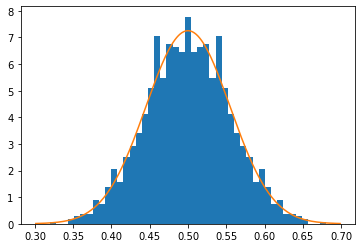

In [ ]:
probabilities = np.array(list(contagens.values())).flatten()
plt.hist(probabilities, bins = round(np.sqrt(len(probabilities))), density = True)

from scipy.stats import norm
mu, s = norm.fit(probabilities)

x1,x2,y1,y2 = plt.axis()
plt.plot(np.linspace(x1,x2,500),norm.pdf(np.linspace(x1,x2,500),mu,s))

In [ ]:
probabilities > ctrl

array([False, False, False, ..., False, False, False])

In [ ]:
ctrl = 2.33441*s+mu

In [ ]:
norm.sf(ctrl,mu,s)*2

0.01957426366661974

# Input de 3 valores

In [ ]:
model_3in = Sequential([
        Dense(3, input_shape = (1,input_length), activation = 'sigmoid'),
        Dense(1000, activation = 'sigmoid'),
        Dense(1000, activation = 'sigmoid'),
        LSTM(1),
        Dense(1, activation = 'sigmoid')
])

model_3in.compile(optimizer='adam', loss='mse', metrics = ['mae'])
model_3in.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 1, 3)              12        
_________________________________________________________________
dense_88 (Dense)             (None, 1, 1000)           4000      
_________________________________________________________________
dense_89 (Dense)             (None, 1, 1000)           1001000   
_________________________________________________________________
lstm_17 (LSTM)               (None, 1)                 4008      
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 2         
Total params: 1,009,022
Trainable params: 1,009,022
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n_epochs = 40
history_3in = model_3in.fit(x_train, y_train, epochs = n_epochs, batch_size=8, validation_data=(x_val, y_val))

In [ ]:
x_train[1]

array([[0.07899396, 0.66650813]])

# 5 inputs

In [ ]:
from scipy.interpolate import NearestNDInterpolator
from scipy.stats import gaussian_kde as kde
import tensorflow_probability as tfp

In [ ]:
model_5in = NearestNDInterpolator(x_train[:,0],y_train)

In [ ]:
points = np.array([list(x_train[i,0])+[y_train[i,0]] for i in range(len(y_train[:,0]))])

In [ ]:
#kde5 = kde(points)

Com TensorFlow